# RL and Advanced DL: Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod
from tictactoe import TicTacToe

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

In [2]:
WIN_VALUE = 1.0
DRAW_VALUE = 0.5
LOSS_VALUE = 0.0


class Agent(ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def action_int(self, state):
        pass

    @abstractmethod
    def action(self, state):
        pass

    @abstractmethod
    def update(self, result):
        pass

    @abstractmethod
    def reset(self):
        pass


class RandomAgent(Agent):
    def __init__(self):
        self.name = "random agent"
        super().__init__()

    def action_int(self, state):
        _, available_actions, _ = state
        return np.random.randint(len(available_actions))

    def action(self, state):
        _, available_actions, _ = state
        return random.choice(available_actions)

    def update(self, result):
        pass

    def reset(self):
        pass


class QAgent(Agent):
    def __init__(
        self,
        alpha=0.9,
        gamma=0.95,
        q_init=0.6,
        n_rows=3,
        n_cols=3,
    ):
        self.name = "q-learning agent"
        self.q = {}
        self.action_history = []
        self.learning_rate = alpha
        self.value_discount = gamma
        self.q_init_val = q_init
        self.n_rows = n_rows
        self.n_cols = n_cols
        super().__init__()

    def get_q(self, state_hash):
        if state_hash in self.q:
            qvals = self.q[state_hash]
        else:
            qvals = np.full(self.n_rows * self.n_cols, self.q_init_val)
            self.q[state_hash] = qvals

        return qvals

    def action_from_int(self, action_int):
        return np.array([int(action_int / self.n_cols), int(action_int % self.n_cols)])

    def action_int(self, state):
        state_hash, available_actions, _ = state
        qvals = self.get_q(state_hash)
        while True:
            int_action = np.argmax(qvals)
            if any(
                np.array_equal(self.action_from_int(int_action), available_action)
                for available_action in available_actions
            ):
                break
            else:
                qvals[int_action] = -1.0
        self.action_history.append((state_hash, int_action))
        return int_action

    def action(self, state):
        int_action = self.action_int(state)
        return self.action_from_int(int_action)

    def update(self, final_value):
        self.action_history.reverse()
        next_max = -1.0

        for h in self.action_history:
            qvals = self.get_q(h[0])
            if next_max < 0:
                qvals[h[1]] = final_value
            else:
                qvals[h[1]] = (
                    qvals[h[1]] * (1.0 - self.learning_rate)
                    + self.learning_rate * self.value_discount * next_max
                )
            next_max = max(qvals)

    def reset(self):
        self.action_history = []


In [3]:
def play_game(
    env: TicTacToe,
    cross: Agent,
    naught: Agent,
    verbose: bool = False,
    fit_agents: bool = True,
) -> int:
    cross.reset()
    naught.reset()
    env.reset()

    state = env.getState()
    done = False
    while not done:
        action = cross.action(state) if env.curTurn == 1 else naught.action(state)
        state, reward, done, _ = env.step(action)

        if verbose:
            env.printBoard()
        if done:
            if reward in [1, -1]:
                cross_final_value = WIN_VALUE if reward == 1 else LOSS_VALUE
                naught_final_value = WIN_VALUE if reward == -1 else LOSS_VALUE
            else:
                cross_final_value = DRAW_VALUE
                naught_final_value = DRAW_VALUE
    if fit_agents:
        cross.update(cross_final_value)
        naught.update(naught_final_value)
    return reward


def tic_tac_toe_battle(
    env: TicTacToe,
    player1: Agent,
    player2: Agent,
    num_games: int = 1000,
    switch_roles: bool = True,
    verbose: bool = False,
    fit_agents=True,
    index_order=[1, 2],
) -> tuple[int, int, int]:
    draw_count = 0
    player_1_count = 0
    player_2_count = 0
    for _ in range(num_games):
        switch_role = np.random.randint(2) if switch_roles else 0
        result = (
            play_game(env, player1, player2, fit_agents=fit_agents)
            if not switch_role
            else play_game(env, player2, player1, fit_agents=fit_agents)
        )
        if not switch_role:
            if result == 1:
                player_1_count += 1
            elif result == -1:
                player_2_count += 1
            else:
                draw_count += 1
        else:
            if result == 1:
                player_2_count += 1
            elif result == -1:
                player_1_count += 1
            else:
                draw_count += 1

    if verbose:
        print(
            f"After {num_games} game percentages of:\n \
                draws: {draw_count / num_games:.2%};\n \
                Player {index_order[0]} {player1.name} wins: {player_1_count / num_games:.2%};\n \
                Player {index_order[1]} {player2.name} wins: {player_2_count / num_games:.2%}"
        )
    return player_1_count, player_2_count, draw_count


def eval_players(
    env: TicTacToe,
    player1: Agent,
    player2: Agent,
    num_battles: int = 1000,
    games_per_battle: int = 100,
    switch_roles: bool = True,
):
    player1_wins = []
    player2_wins = []
    draws = []
    count = []
    for i in range(num_battles):
        player1_win, player2_win, draw = tic_tac_toe_battle(
            env, player1, player2, games_per_battle, switch_roles
        )
        player1_wins.append(player1_win * 100.0 / games_per_battle)
        player2_wins.append(player2_win * 100.0 / games_per_battle)
        draws.append(draw * 100.0 / games_per_battle)
        count.append(i * games_per_battle)

    plt.ylabel("Game outcomes in %")
    plt.xlabel("Game number")
    plt.plot(count, draws, "r-", label="Draw")
    plt.plot(count, player1_wins, "g-", label="Player 1 wins")
    plt.plot(count, player2_wins, "b-", label="Player 2 wins")
    plt.legend(loc="best", shadow=True, fancybox=True, framealpha=0.7)


def get_report(
    env: TicTacToe,
    player1: Agent,
    player2: Agent,
    num_games: int = 1000,
) -> None:
    print(
        f"Player 1 ({player1.name}) vs Player 2 ({player2.name}) (switch_roles=False):\n",
        end="\t",
    )
    tic_tac_toe_battle(
        env,
        player1,
        player2,
        num_games,
        switch_roles=False,
        fit_agents=False,
        verbose=True,
    )
    print(
        f"Player 1 ({player1.name}) vs Player 2 ({player2.name}) (switch_roles=True):\n",
        end="\t",
    )
    tic_tac_toe_battle(
        env,
        player1,
        player2,
        num_games,
        switch_roles=True,
        fit_agents=False,
        verbose=True,
    )
    print(
        f"Player 2 ({player2.name}) vs Player 1 ({player1.name}) (switch_roles=False):\n",
        end="\t",
    )
    tic_tac_toe_battle(
        env,
        player2,
        player1,
        num_games,
        switch_roles=False,
        fit_agents=False,
        verbose=True,
        index_order=[2, 1],
    )


### Доска 3x3

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

Первым делом посмотрим как будут "игарть" игроки с рандомными стратегими, не менясь (первый игрок всегда ходит первым (крестиками)):

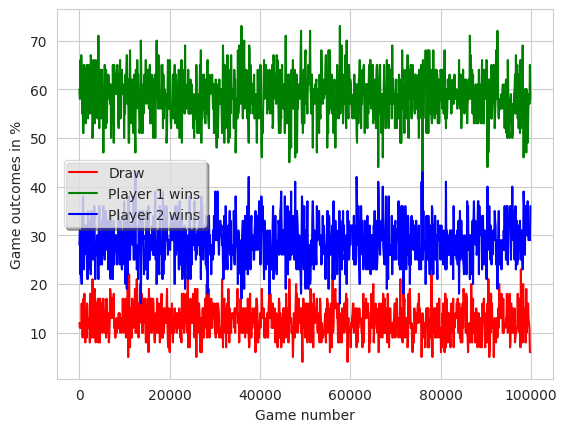

In [157]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
rand_player_1 = RandomAgent()
rand_player_2 = RandomAgent()
eval_players(
    env,
    rand_player_1,
    rand_player_2,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=False,
)


У того, кто ходит первым явное преимущество)  
Если случайным образом менять очерёдностью хода:

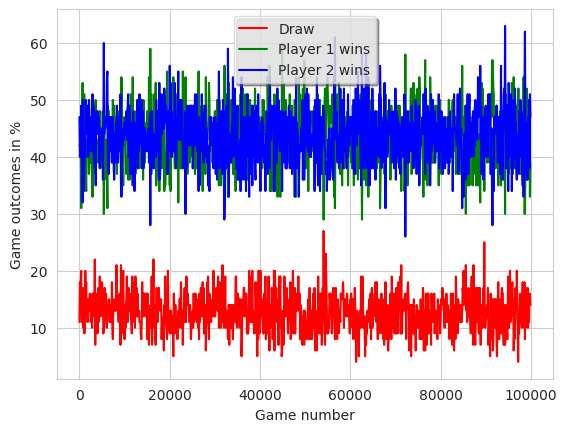

In [158]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
rand_player_1 = RandomAgent()
rand_player_2 = RandomAgent()
eval_players(
    env,
    rand_player_1,
    rand_player_2,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)


Всё по-честному)

#### Q-learning agent vs random agent (Q-learning agent всегда ходит первым)

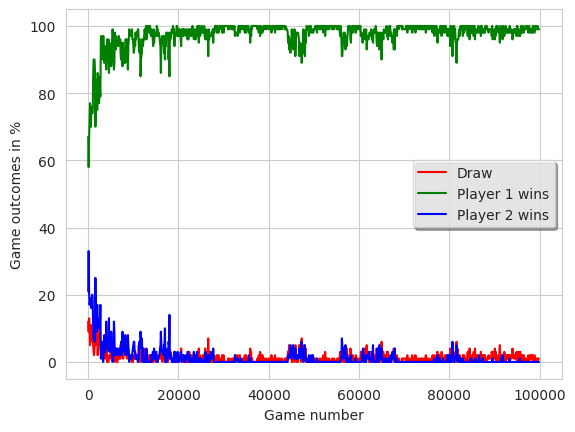

In [176]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.5, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=False,
)


In [177]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 1.60%;
                 Player 1 q-learning agent wins: 98.40%;
                 Player 2 random agent wins: 0.00%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 2.30%;
                 Player 1 q-learning agent wins: 69.80%;
                 Player 2 random agent wins: 27.90%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 4.10%;
                 Player 2 random agent wins: 54.20%;
                 Player 1 q-learning agent wins: 41.70%


Q-learning agent, который при обучении против случайной стратегии всегда начинал игру первым, показывает сильные результаты начиная игру первым, чуть хуже справляется, когда очерёдность первого хода игроками определяется случайно, и показывает себя очень плохо когда начинает игру вторым.

#### Q-learning agent vs random agent (слайчая очерёдность первохого хода)

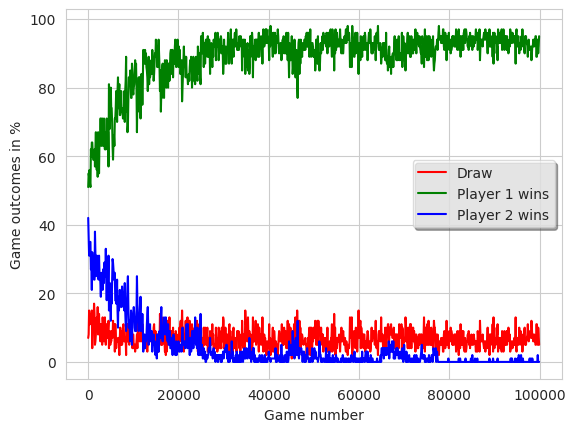

In [178]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.5, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)

In [179]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 0.50%;
                 Player 1 q-learning agent wins: 99.50%;
                 Player 2 random agent wins: 0.00%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 4.60%;
                 Player 1 q-learning agent wins: 95.00%;
                 Player 2 random agent wins: 0.40%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 12.30%;
                 Player 2 random agent wins: 1.30%;
                 Player 1 q-learning agent wins: 86.40%


С такой стратегией обучения получаются более стабильные результаты!

### Доска 4x4

In [268]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

#### Q-learning agent vs random agent (Q-learning agent всегда ходит первым)

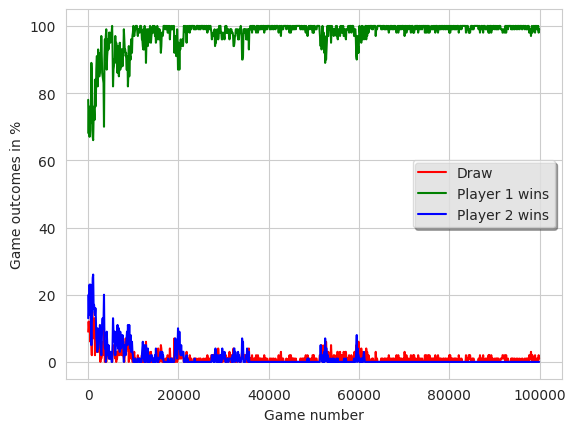

In [274]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.5, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=False,
)

In [275]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 0.80%;
                 Player 1 q-learning agent wins: 99.20%;
                 Player 2 random agent wins: 0.00%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 1.80%;
                 Player 1 q-learning agent wins: 73.00%;
                 Player 2 random agent wins: 25.20%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 3.90%;
                 Player 2 random agent wins: 54.00%;
                 Player 1 q-learning agent wins: 42.10%


Результаты аналогичные случаю обучения на доске размера 3x3

#### Q-learning agent vs random agent (слайчая очерёдность первохого хода)

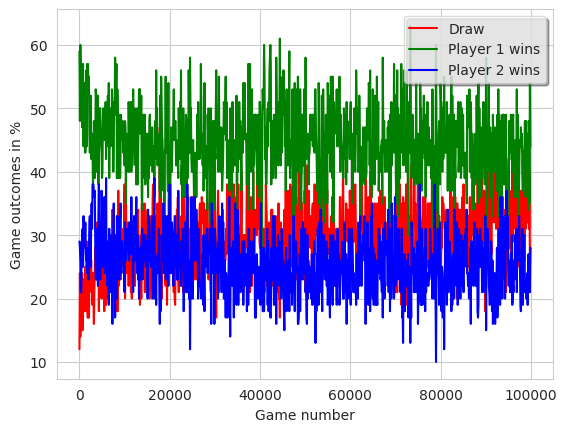

In [181]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.5, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)

In [182]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 31.00%;
                 Player 1 q-learning agent wins: 48.40%;
                 Player 2 random agent wins: 20.60%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 32.50%;
                 Player 1 q-learning agent wins: 42.20%;
                 Player 2 random agent wins: 25.30%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 30.40%;
                 Player 2 random agent wins: 27.90%;
                 Player 1 q-learning agent wins: 41.70%


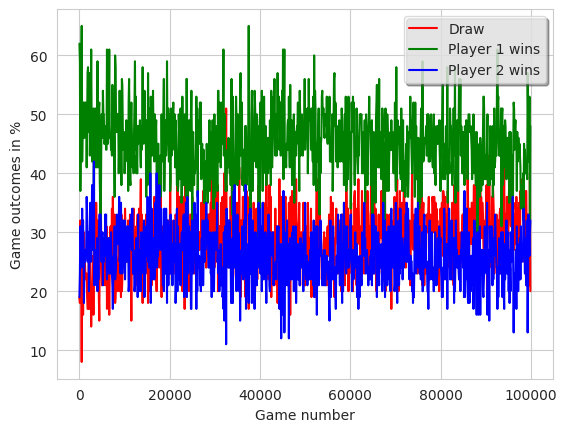

In [183]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.8, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)

In [184]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 28.90%;
                 Player 1 q-learning agent wins: 51.90%;
                 Player 2 random agent wins: 19.20%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 31.00%;
                 Player 1 q-learning agent wins: 45.80%;
                 Player 2 random agent wins: 23.20%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 32.30%;
                 Player 2 random agent wins: 25.50%;
                 Player 1 q-learning agent wins: 42.20%


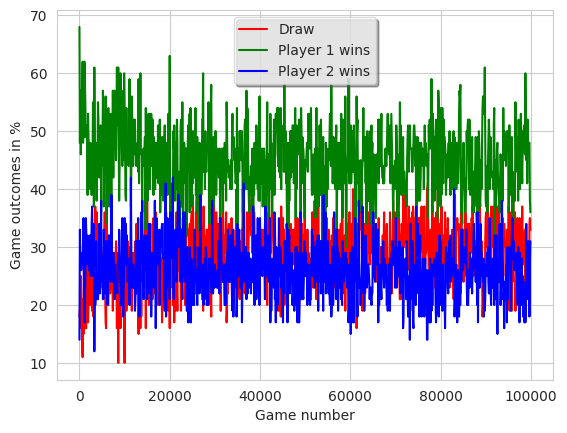

In [185]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.9, gamma=0.5, q_init=0.8, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)

In [186]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 30.10%;
                 Player 1 q-learning agent wins: 44.50%;
                 Player 2 random agent wins: 25.40%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 30.50%;
                 Player 1 q-learning agent wins: 41.20%;
                 Player 2 random agent wins: 28.30%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 31.20%;
                 Player 2 random agent wins: 29.10%;
                 Player 1 q-learning agent wins: 39.70%


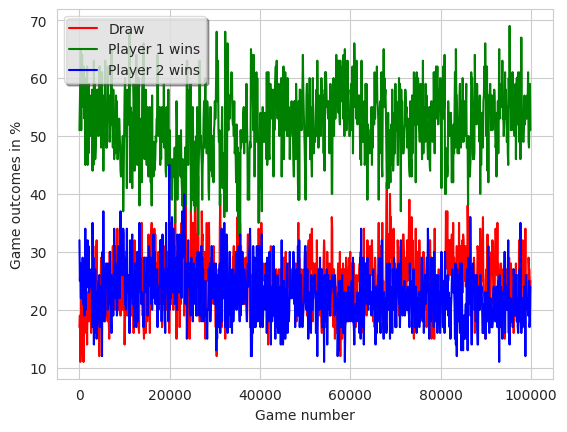

In [187]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.9, gamma=0.9, q_init=0.8, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=True,
)

In [188]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 22.10%;
                 Player 1 q-learning agent wins: 59.50%;
                 Player 2 random agent wins: 18.40%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 26.70%;
                 Player 1 q-learning agent wins: 52.20%;
                 Player 2 random agent wins: 21.10%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 29.40%;
                 Player 2 random agent wins: 27.40%;
                 Player 1 q-learning agent wins: 43.20%


На более крупной доске (4х4), q-learning агент играет лучше чем агент с рандомной стратегией, но полностью обобщить стратегию не моежет. Подбор параметров несколько улучшает качество работы q-learning агента, но незначительно.  

### Доска 5x5

In [276]:
N_ROWS, N_COLS, N_WIN = 5, 5, 5

#### Q-learning agent vs random agent (Q-learning agent всегда ходит первым)

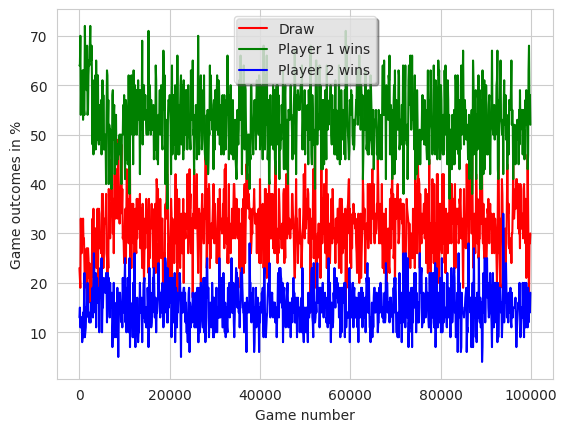

In [277]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
q_player = QAgent(alpha=0.5, gamma=0.5, q_init=0.5, n_rows=N_ROWS, n_cols=N_COLS)
rand_player = RandomAgent()
eval_players(
    env,
    q_player,
    rand_player,
    num_battles=1000,
    games_per_battle=100,
    switch_roles=False,
)

In [278]:
get_report(env, q_player, rand_player)

Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 23.00%;
                 Player 1 q-learning agent wins: 64.20%;
                 Player 2 random agent wins: 12.80%
Player 1 (q-learning agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 15.40%;
                 Player 1 q-learning agent wins: 60.50%;
                 Player 2 random agent wins: 24.10%
Player 2 (random agent) vs Player 1 (q-learning agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 10.30%;
                 Player 2 random agent wins: 36.00%;
                 Player 1 q-learning agent wins: 53.70%


## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
 
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.  
4. Реализуйте Double DQN и/или Dueling DQN.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
from collections import deque
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Deep Q-Network

In [10]:
EMPTY = 0
CROSSES_TURN = 1
NOUGHTS_TURN = -1

class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def store(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size: int = 64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_rows, n_cols, hidden_dim: int = 256):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 2 * hidden_dim, n_cols).to(device)
        self.l1 = nn.Linear(2 * hidden_dim, hidden_dim).to(device)
        self.l2 = nn.Linear(hidden_dim, n_rows * n_cols).to(device)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x


class DQNAgent(Agent):
    def __init__(self, n_rows, n_cols, lr: float = 1e-5, memory_capacity: int = 30000):
        super().__init__()
        self.reset()
        self.name = "DQN agent"
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.model = DQN(self.n_rows, self.n_cols)
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.memory = ReplayMemory(capacity=memory_capacity)

    def action_from_int(self, action_int):
        return np.array([int(action_int / self.n_cols), int(action_int % self.n_cols)])

    def action_int(self, state, eps: float = 0.1):
        t_board, _, _  = state
        board = np.array(t_board).reshape(self.n_rows, self.n_cols)
        if random.random() < eps:
            int_action = random.choice(np.nonzero(board.flatten() == 0)[0])
            return int_action

        self.model.eval()
        board = np.stack(
            [
                (board == CROSSES_TURN).astype(float),
                (board == NOUGHTS_TURN).astype(float),
                (board == EMPTY).astype(float)
            ]
        )
        torch_board = torch.FloatTensor(board).unsqueeze(0).to(device)
        int_action = self.model(torch_board).detach().max(1).indices.item()
        return int_action

    def action(self, state):
        int_action = self.action_int(state)
        return self.action_from_int(int_action)

    def update(self, new_state, action, reward, done):
        t_board, _, _  = new_state
        new_board = np.array(t_board).reshape(self.n_rows, self.n_cols)
        new_board = np.stack(
            [
                (new_board == CROSSES_TURN).astype(float),
                (new_board == NOUGHTS_TURN).astype(float),
                (new_board == EMPTY).astype(float)
            ]
        )
        if self.board is not None:
            self.memory.store((self.board, new_board, self.int_action, reward, done))
        self.board = new_board
        self.int_action = action
    
    def train_batch(self, batch_size=256, gamma=0.9):    
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        board, next_board, actions, rewards, dones = list(zip(*transitions))
        
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        batch_board = torch.FloatTensor(np.array(board)).to(device)
        batch_next_board = torch.FloatTensor(np.array(next_board)).to(device)
        batch_actions = torch.LongTensor(actions).reshape(-1, 1).to(device)
        batch_reward = torch.FloatTensor(rewards).reshape(-1, 1).to(device)
        batch_dones = torch.BoolTensor(rewards).reshape(-1, 1).to(device)

        self.model.train()
        Q = self.model(batch_board).gather(1, batch_actions)

        with torch.no_grad():
            Qnext = self.model(batch_next_board).max(dim=1).values.reshape(-1, 1)
            Qnext[batch_dones] = 0
            Qnext = batch_reward + gamma * Qnext

        loss = F.l1_loss(Q, Qnext)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def reset(self):
        self.int_action = None 
        self.reward = None
        self.board = None
        self.new_board = None


class RandomDQNAgent(DQNAgent):
    def __init__(self, n_rows, n_cols, lr: float = 1e-5, memory_capacity: int = 30000):
        super().__init__(n_rows, n_cols)
        self.name = "Random agent"
    
    def action_int(self, state, eps):
        _, available_actions, _ = state
        return np.random.randint(len(available_actions))

    def action(self, state, eps):
        _, available_actions, _ = state
        return random.choice(available_actions)

    def update(self, new_state, action, reward, done):
        pass

    def train_batch(self, batch_size=256, gamma=0.9): 
        pass

    def reset(self):
        pass
    

def dqn_fit_game(
    env: TicTacToe,
    cross: DQNAgent,
    naught: DQNAgent,
    args: dict
) -> int:
    cross.model.eval()
    naught.model.eval()
    cross.reset()
    naught.reset()
    env.reset()
        
    state = env.getState()

    done = False
    while not done:
        current = cross if env.curTurn == 1 else naught
        int_action = current.action_int(state, args['eps'])
        current.update(state, int_action, 0, done)
        state, reward, done, _ = env.step(env.action_from_int(int_action))
    if reward == -10:
        current.update(state, int_action, reward, done)
    else:
        cross.update(state, int_action, reward, done)
        naught.update(state, int_action, -reward, done)
    cross.train_batch(args['batch_size'], args['gamma'])
    naught.train_batch(args['batch_size'], args['gamma'])
    return reward

def dqn_battle(
    env: TicTacToe,
    player1: DQNAgent,
    player2: DQNAgent,
    args,
    num_games: int = 1000,
    switch_roles: bool = True,
    verbose: bool = False,
    index_order=[1, 2],
    
) -> tuple[int, int, int]:
    draw_count = 0
    player_1_count = 0
    player_2_count = 0
    for _ in range(num_games):
        switch_role = np.random.randint(2) if switch_roles else 0
        result = (
            dqn_fit_game(env, player1, player2, args)
            if not switch_role
            else dqn_fit_game(env, player2, player1, args)
        )
        if not switch_role:
            if result == 1:
                player_1_count += 1
            elif result == -1:
                player_2_count += 1
            else:
                draw_count += 1
        else:
            if result == 1:
                player_2_count += 1
            elif result == -1:
                player_1_count += 1
            else:
                draw_count += 1

    if verbose:
        print(
            f"After {num_games} game percentages of:\n \
                draws: {draw_count / num_games:.2%};\n \
                Player {index_order[0]} {player1.name} wins: {player_1_count / num_games:.2%};\n \
                Player {index_order[1]} {player2.name} wins: {player_2_count / num_games:.2%}"
        )
    return player_1_count, player_2_count, draw_count



def train_dqn(
    env: TicTacToe,
    player1: DQNAgent,
    player2: DQNAgent,
    args: dict,
    num_battles: int = 1000,
    games_per_battle: int = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles: bool = True,
):
    player1_wins = []
    player2_wins = []
    draws = []
    count = []
    eps_decay = int(num_battles * 0.8)
    for epoch in tqdm(range(num_battles)): 
        args['eps'] = eps_init + (eps_final - eps_init) * epoch / eps_decay
        player1_win, player2_win, draw = dqn_battle(
            env, player1, player2, args, games_per_battle, switch_roles
        )
        player1_wins.append(player1_win * 100.0 / games_per_battle)
        player2_wins.append(player2_win * 100.0 / games_per_battle)
        draws.append(draw * 100.0 / games_per_battle)
        count.append(epoch * games_per_battle)
    plt.ylabel("Game outcomes in %")
    plt.xlabel("Game number")
    plt.plot(count, draws, "r-", label="Draw")
    plt.plot(count, player1_wins, "g-", label="Player 1 wins")
    plt.plot(count, player2_wins, "b-", label="Player 2 wins")
    plt.legend(loc="best", shadow=True, fancybox=True, framealpha=0.7)

### Доска 3x3

In [11]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

#### Deep Q-Network agent (Очерёдность ходов не меняется)

100%|██████████| 1000/1000 [10:01<00:00,  1.66it/s]


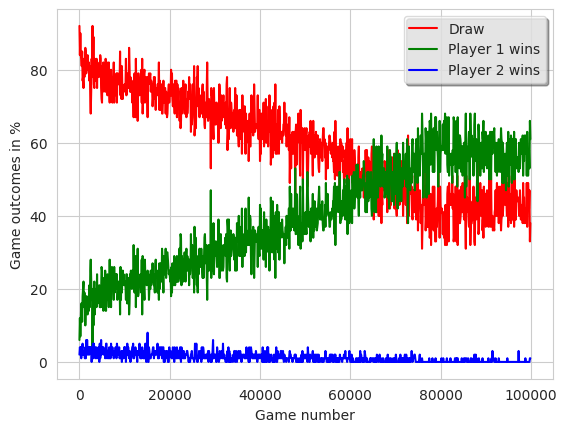

In [13]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [14]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 15.80%;
                 Player 1 DQN agent wins: 78.30%;
                 Player 2 random agent wins: 5.90%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 31.60%;
                 Player 1 DQN agent wins: 59.90%;
                 Player 2 random agent wins: 8.50%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 45.00%;
                 Player 2 random agent wins: 16.40%;
                 Player 1 DQN agent wins: 38.60%


100%|██████████| 1000/1000 [23:37<00:00,  1.42s/it]


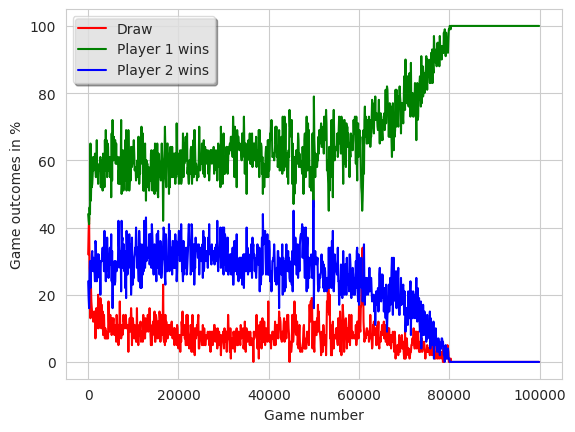

In [61]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [62]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 3.10%;
                 Player 1 DQN agent wins: 94.90%;
                 Player 2 random agent wins: 2.00%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 24.50%;
                 Player 1 DQN agent wins: 69.90%;
                 Player 2 random agent wins: 5.60%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 46.90%;
                 Player 2 random agent wins: 7.50%;
                 Player 1 DQN agent wins: 45.60%


#### Deep Q-Network agent (Очерёдность хода меняется случайным образом)

100%|██████████| 1000/1000 [09:57<00:00,  1.67it/s]


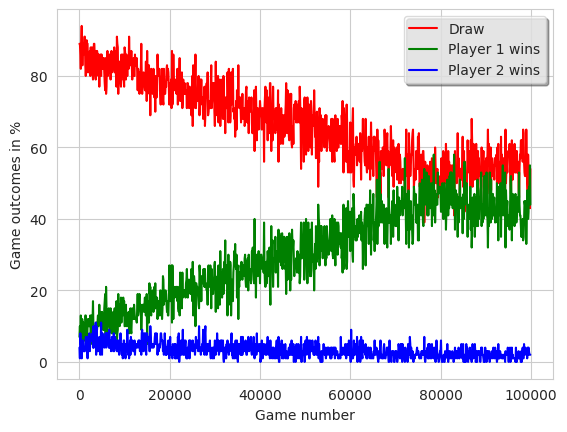

In [15]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [16]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 4.10%;
                 Player 1 DQN agent wins: 89.40%;
                 Player 2 random agent wins: 6.50%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 6.60%;
                 Player 1 DQN agent wins: 80.10%;
                 Player 2 random agent wins: 13.30%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 6.30%;
                 Player 2 random agent wins: 18.00%;
                 Player 1 DQN agent wins: 75.70%


100%|██████████| 1000/1000 [22:25<00:00,  1.35s/it]


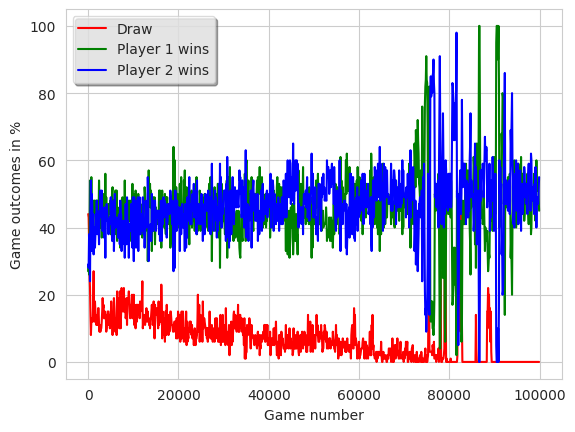

In [63]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [64]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 1.20%;
                 Player 1 DQN agent wins: 95.40%;
                 Player 2 random agent wins: 3.40%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 12.20%;
                 Player 1 DQN agent wins: 75.50%;
                 Player 2 random agent wins: 12.30%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 20.10%;
                 Player 2 random agent wins: 24.40%;
                 Player 1 DQN agent wins: 55.50%


### Доска 4x4

In [17]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

#### Deep Q-Network agent (Очерёдность ходов не меняется)

100%|██████████| 1000/1000 [11:14<00:00,  1.48it/s]


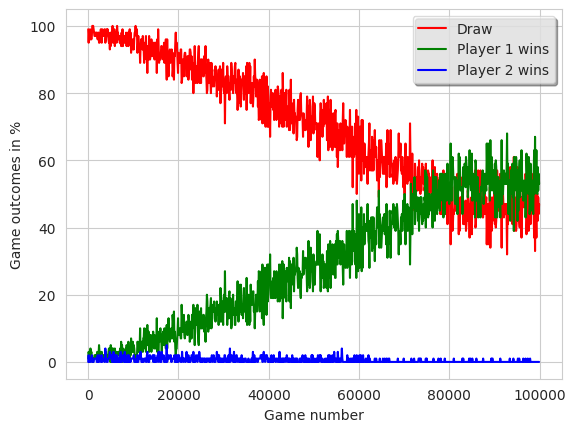

In [18]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [19]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 26.50%;
                 Player 1 DQN agent wins: 72.20%;
                 Player 2 random agent wins: 1.30%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 56.50%;
                 Player 1 DQN agent wins: 34.40%;
                 Player 2 random agent wins: 9.10%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 84.20%;
                 Player 2 random agent wins: 14.20%;
                 Player 1 DQN agent wins: 1.60%


100%|██████████| 1000/1000 [24:55<00:00,  1.50s/it]


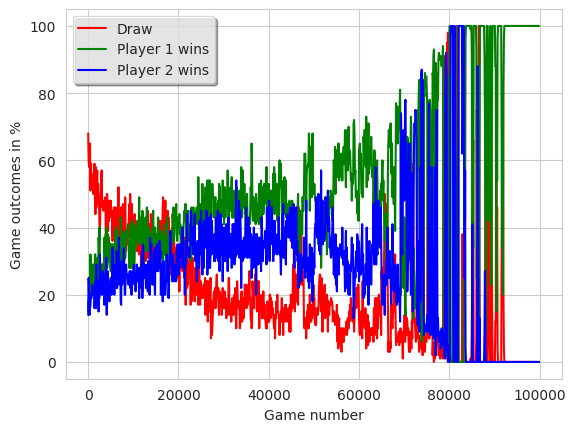

In [67]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [68]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 48.90%;
                 Player 1 DQN agent wins: 45.00%;
                 Player 2 random agent wins: 6.10%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 63.70%;
                 Player 1 DQN agent wins: 27.60%;
                 Player 2 random agent wins: 8.70%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 75.50%;
                 Player 2 random agent wins: 11.90%;
                 Player 1 DQN agent wins: 12.60%


#### Deep Q-Network agent (Очерёдность хода меняется случайным образом)

100%|██████████| 1000/1000 [11:07<00:00,  1.50it/s]


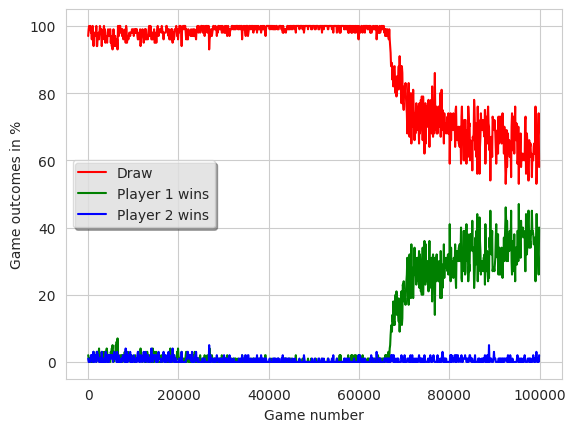

In [20]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [21]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 44.70%;
                 Player 1 DQN agent wins: 53.80%;
                 Player 2 random agent wins: 1.50%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 60.50%;
                 Player 1 DQN agent wins: 37.00%;
                 Player 2 random agent wins: 2.50%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 74.70%;
                 Player 2 random agent wins: 4.50%;
                 Player 1 DQN agent wins: 20.80%


100%|██████████| 1000/1000 [25:44<00:00,  1.54s/it]


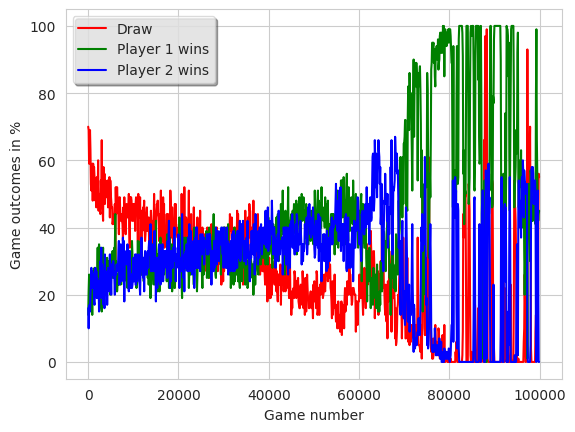

In [70]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn_player1 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
dqn_player2 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = dqn_player1,
    player2 = dqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [71]:
rand_player = RandomAgent()
get_report(env, dqn_player1, rand_player)

Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 39.30%;
                 Player 1 DQN agent wins: 55.90%;
                 Player 2 random agent wins: 4.80%
Player 1 (DQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 56.50%;
                 Player 1 DQN agent wins: 37.30%;
                 Player 2 random agent wins: 6.20%
Player 2 (random agent) vs Player 1 (DQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 68.50%;
                 Player 2 random agent wins: 9.30%;
                 Player 1 DQN agent wins: 22.20%


### Double Deep Q-Network

In [24]:
class DDQNAgent(DQNAgent):
    def __init__(self, n_rows, n_cols, lr: float = 1e-5, memory_capacity: int = 30000):
        super().__init__(n_rows, n_cols, lr, memory_capacity)
        self.name = "DDQN agent"
        # self.n_rows = n_rows
        # self.n_cols = n_cols
        # self.model = DQN(self.n_rows, self.n_cols)
        self.steps = 0
        self.target_model = copy.deepcopy(self.model) 
    
    def __train_batch(self, batch_size=256, gamma=0.9):    
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        states, next_states, actions, rewards, dones = list(zip(*transitions))
        
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        batch_state = torch.FloatTensor(states).to(device)
        batch_next_state = torch.FloatTensor(next_states).to(device)
        batch_actions = torch.LongTensor(actions).reshape(-1, 1).to(device)
        batch_reward = torch.FloatTensor(rewards).reshape(-1, 1).to(device)
        batch_dones = torch.BoolTensor(rewards).reshape(-1, 1).to(device)

        self.model.train()
        Q = self.model(batch_state).gather(1, batch_actions)

        with torch.no_grad():
            Qnext = self.target_model(batch_next_state).max(dim=1).values.reshape(-1, 1)
            Qnext[batch_dones] = 0
            Qnext = batch_reward + gamma * Qnext

        loss = F.l1_loss(Q, Qnext)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_batch(
        self, batch_size=256, gamma=0.9,
        steps_per_update=4, 
        steps_per_target_update=4*100
    ):
        if self.steps % steps_per_update == 0:
            self.__train_batch(batch_size, gamma)
        if self.steps % steps_per_target_update == 0:
            self.update_target_model()
        self.steps += 1

### Доска 3x3

In [25]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

#### Double Deep Q-Network agent (Очерёдность ходов не меняется)

100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s]


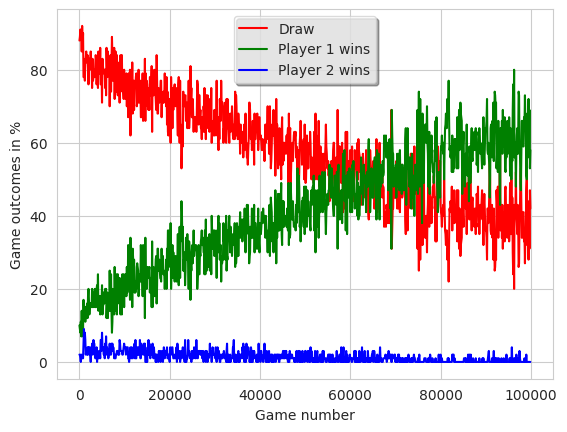

In [26]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [27]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 1.70%;
                 Player 1 DDQN agent wins: 93.10%;
                 Player 2 random agent wins: 5.20%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 30.70%;
                 Player 1 DDQN agent wins: 62.00%;
                 Player 2 random agent wins: 7.30%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 56.20%;
                 Player 2 random agent wins: 15.60%;
                 Player 1 DDQN agent wins: 28.20%


100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


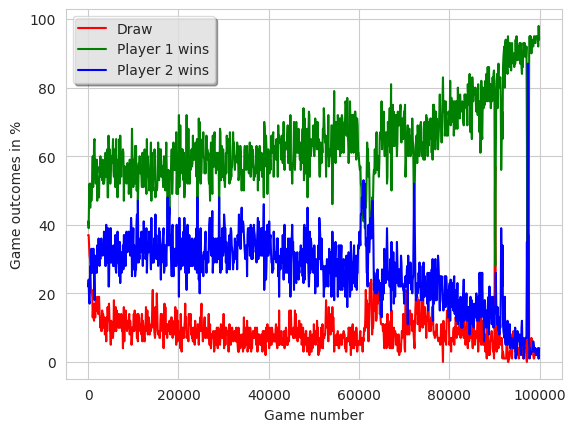

In [74]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = DQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.2,
    switch_roles = False,
)

In [75]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 1.90%;
                 Player 1 DDQN agent wins: 97.00%;
                 Player 2 random agent wins: 1.10%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 23.70%;
                 Player 1 DDQN agent wins: 72.10%;
                 Player 2 random agent wins: 4.20%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 43.00%;
                 Player 2 random agent wins: 7.50%;
                 Player 1 DDQN agent wins: 49.50%


#### Deep Q-Network agent (Очерёдность хода меняется случайным образом)

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


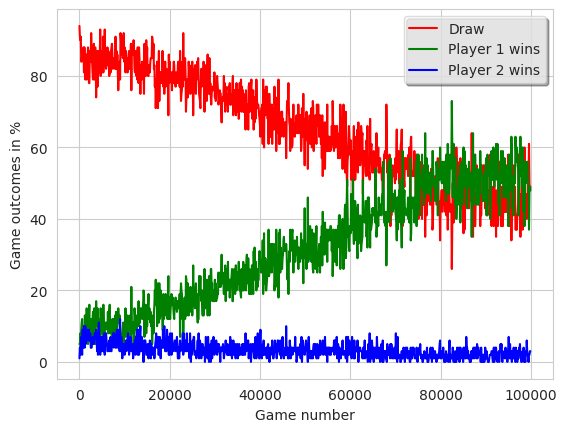

In [28]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [29]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 9.50%;
                 Player 1 DDQN agent wins: 88.00%;
                 Player 2 random agent wins: 2.50%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 10.00%;
                 Player 1 DDQN agent wins: 81.60%;
                 Player 2 random agent wins: 8.40%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 10.70%;
                 Player 2 random agent wins: 14.90%;
                 Player 1 DDQN agent wins: 74.40%


100%|██████████| 1000/1000 [09:19<00:00,  1.79it/s]


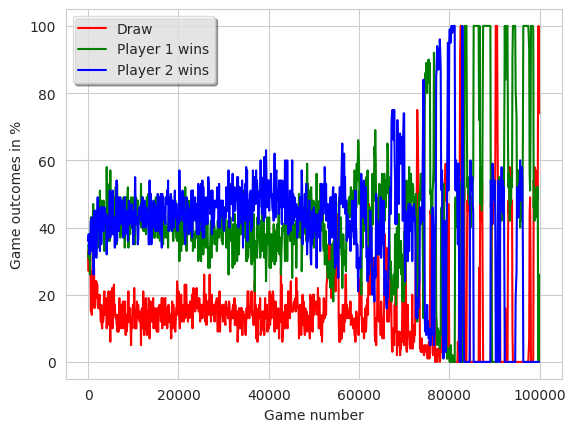

In [76]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [77]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 19.00%;
                 Player 1 DDQN agent wins: 62.60%;
                 Player 2 random agent wins: 18.40%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 17.10%;
                 Player 1 DDQN agent wins: 53.10%;
                 Player 2 random agent wins: 29.80%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 13.70%;
                 Player 2 random agent wins: 39.60%;
                 Player 1 DDQN agent wins: 46.70%


### Доска 4x4

In [30]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

#### Deep Q-Network agent (Очерёдность ходов не меняется)

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


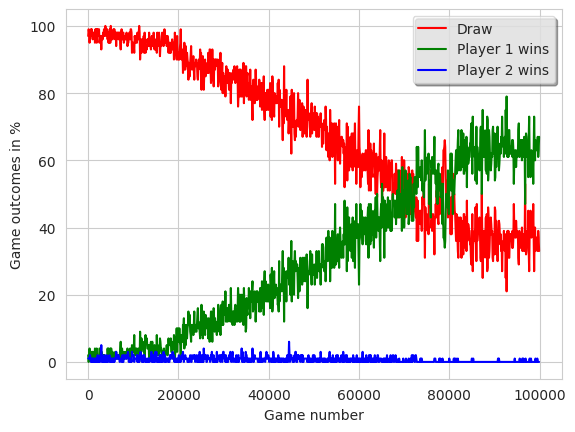

In [31]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [32]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 14.20%;
                 Player 1 DDQN agent wins: 80.80%;
                 Player 2 random agent wins: 5.00%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 51.10%;
                 Player 1 DDQN agent wins: 39.30%;
                 Player 2 random agent wins: 9.60%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 81.40%;
                 Player 2 random agent wins: 14.40%;
                 Player 1 DDQN agent wins: 4.20%


100%|██████████| 1000/1000 [11:51<00:00,  1.41it/s]


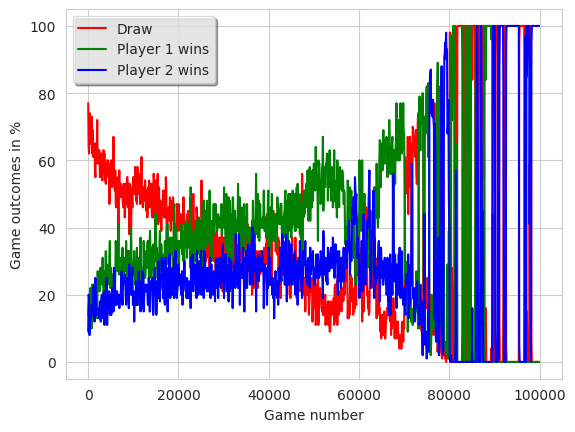

In [80]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [81]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 85.60%;
                 Player 1 DDQN agent wins: 10.50%;
                 Player 2 random agent wins: 3.90%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 87.40%;
                 Player 1 DDQN agent wins: 6.70%;
                 Player 2 random agent wins: 5.90%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 89.10%;
                 Player 2 random agent wins: 7.90%;
                 Player 1 DDQN agent wins: 3.00%


#### Deep Q-Network agent (Очерёдность хода меняется случайным образом)

100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


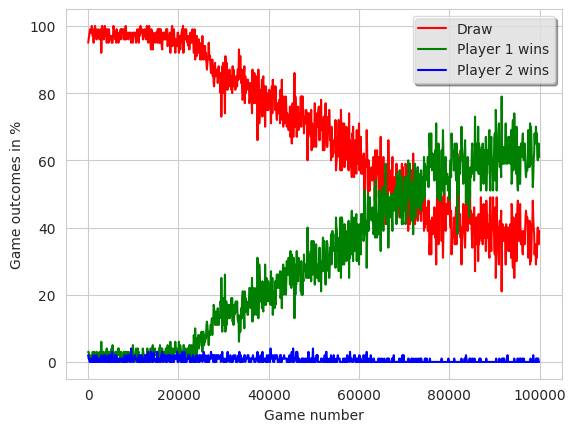

In [33]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = RandomDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = False,
)

In [34]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 14.60%;
                 Player 1 DDQN agent wins: 82.10%;
                 Player 2 random agent wins: 3.30%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 50.70%;
                 Player 1 DDQN agent wins: 42.70%;
                 Player 2 random agent wins: 6.60%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 89.00%;
                 Player 2 random agent wins: 8.10%;
                 Player 1 DDQN agent wins: 2.90%


100%|██████████| 1000/1000 [13:07<00:00,  1.27it/s]


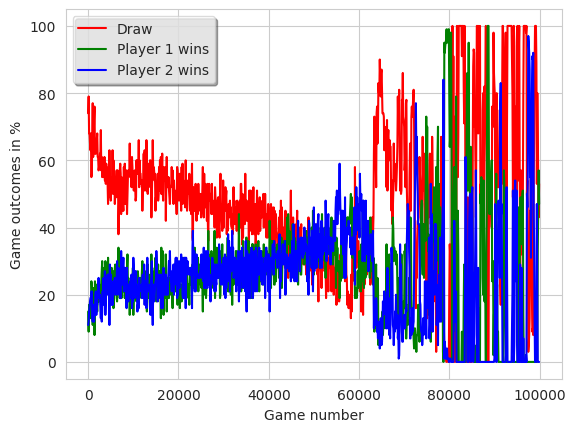

In [82]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
ddqn_player1 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
ddqn_player2 = DDQNAgent(n_rows=N_ROWS, n_cols=N_COLS)
train_dqn(
    env = env,
    player1 = ddqn_player1,
    player2 = ddqn_player2,
    args = {'batch_size': 512, 'gamma': 0.9},
    num_battles = 1000,
    games_per_battle = 100,
    eps_init = 0.9,
    eps_final = 0.01,
    switch_roles = True,
)

In [83]:
rand_player = RandomAgent()
get_report(env, ddqn_player1, rand_player)

Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 55.50%;
                 Player 1 DDQN agent wins: 36.00%;
                 Player 2 random agent wins: 8.50%
Player 1 (DDQN agent) vs Player 2 (random agent) (switch_roles=True):
	After 1000 game percentages of:
                 draws: 60.90%;
                 Player 1 DDQN agent wins: 31.50%;
                 Player 2 random agent wins: 7.60%
Player 2 (random agent) vs Player 1 (DDQN agent) (switch_roles=False):
	After 1000 game percentages of:
                 draws: 67.10%;
                 Player 2 random agent wins: 7.10%;
                 Player 1 DDQN agent wins: 25.80%


Без изменения очерёдности на доске 3x3 DQN и DDQN показывают сильный результаты, при этом не важно против какого агента обучается, что интересно, при изменении очерёдности результаты не стабильны, тоже самое наблюдается на доске 4х4, есть подозрение, что не хвататет эпох обучения. 